In [1]:
data_path = '/home/sthomas/projects/sensitivity_analysis'

In [2]:
import signac
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
from scipy.signal import argrelextrema as argex
import matplotlib.cm as cm
import itertools
from common import *
            
names={'iso':'Isothermal','lin_ramp':'Linear Ramp','step':'Step'}
colors={'iso':'C0','lin_ramp':'C1','step':'C2'}
markers={'iso':'s','lin_ramp':'P','step':'>'}
linestyles={'iso':'-','lin_ramp':'--','step':'-.'}

def init_project():
    df_index = pd.DataFrame(project.index())
    df_index = df_index.set_index(['_id'])
    statepoints = {doc['_id']: doc['statepoint'] for doc in project.index()}
    #print(statepoints)
    df = pd.DataFrame(statepoints).T.join(df_index)
    df = df.sort_values('T')
    return df
project = signac.get_project(data_path)
df = init_project()

In [3]:
df_filtered = df[(df.activation_energy==3.0)&
                  (df.stop_after_percent==100.0)&
                 (df.profile=='step_SA')]
df['t1'] = df_filtered['temp_prof'].str[1].str[0]

In [4]:
df_filtered = df[(df.stop_after_percent==100.0)&
                 (df.profile=='ramp_up_and_down')]
df['t1'] = df_filtered['temp_prof'].str[1].str[0]
df['t2'] = df_filtered['temp_prof'].str[3].str[0]
df['T2'] = df_filtered['temp_prof'].str[4].str[1]
df['t_SetT'] = df['t2']

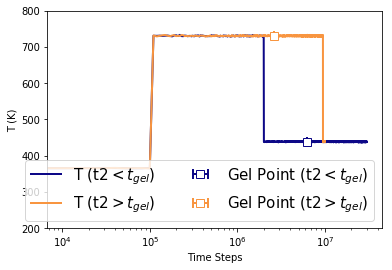

In [5]:
import matplotlib.patheffects as pe
fig = plt.figure()
ax1 = fig.add_subplot(111)
lines=[]
time_conversion = 1.05e-11 #s
distance_conversion = 1.06 #nm
TemperatureConversion = 365.01 #K
df_filtered = df[(df.activation_energy==3.0)&
                 (df.stop_after_percent==100.0)&
                 (df.t1==1.05e5)&
                 (df.E_factor==1.0)&
                 (df.T2==1.2)&
                 (((df.t2==2005001)&(df.t_Final==3e7))|
                  ((df.t2==9505001)&(df.t_Final==1.0e7)))&
                 (df.n_particles==4e5)&
                 (df.profile=='ramp_up_and_down')]
df_sorted = df_filtered.sort_values('t2')
colors = plt.cm.plasma(np.linspace(0,0.75,len(df_sorted.groupby('t2'))))
for i,(key,dfgrp) in enumerate(df_sorted.groupby('t2')):
    for jobid in dfgrp.index:
        job=project.open_job(id=jobid)
        if job.isfile('out.log') and ('gel_point' in job.document) :
            #print(job,key)
            data = np.genfromtxt(job.fn('out.log'),names=True)
            timesteps = data['timestep']
            temperature = data['temperature']
            pops=[]
            pops = [ temp_i+1 for temp_i, (x, y) in enumerate(zip(timesteps,timesteps[1:])) if x>=y]
            if len(pops)>0:
                #print(len(pops),pops)
                timesteps = np.asarray([x for i,x in enumerate(timesteps) if i not in pops])
                temperature   = np.asarray([x for i,x in enumerate(temperature) if i not in pops])
            temperature = temperature*TemperatureConversion
            gel_point = job.document['gel_point']
            T_at_gel = temperature[np.isclose(timesteps,gel_point)]
            #print(T_at_gel)
            if job.sp.trial==1:
                if key<gel_point:
                    label='T (t2'+'$< t_{gel}$)'
                else:
                    label='T (t2'+'$> t_{gel}$)'
                ax1.plot(timesteps,
                         temperature,
                         linewidth=2.0,
                        color=colors[i],
                         label=label)
                        #label='T (t2 : {:.1e})'.format(key))

            if False:
                ax1.axvline(x=job.document['gel_point'],
                           color=colors[i],
                           linestyle='--',
                           linewidth=1.0,
                           label='Gel Point')
    if True:
        if key<gel_point:
            label='Gel Point (t2'+'$< t_{gel}$)'
        else:
            label='Gel Point (t2'+'$> t_{gel}$)'
        ax1.errorbar(x=dfgrp.gel_point.mean(),
                    y=T_at_gel,#400,
                    xerr=dfgrp.gel_point.std(),
                     label=label,#'$t_{gel}$'+' (t2 : {:.1e})'.format(key),
                     color=colors[i],#'r',
                     fmt='s',
                     markerfacecolor='w',
                     lw=3,
                     ms=8,
                     capthick=2,
                     elinewidth=2,
                     capsize=5,
                    zorder=2)
if False:
    ax1.axvline(x=df_filtered.gel_point.mean(),
                color='r',
                linestyle='--',
                linewidth=4.0,
                path_effects=[pe.Stroke(linewidth=5, foreground='k'), pe.Normal()])
    ax1.errorbar(x=df_filtered.gel_point.mean(),
                y=300,
                xerr=df_filtered.gel_point.std(),
                 label='Gel Point',
                 color='r',
                 fmt='o',
                 markerfacecolor='w',
                 markeredgecolor='r',
                 lw=3,
                 ms=8,
                 capthick=2,
                 elinewidth=3,
                 capsize=5,
                zorder=2)
ax1.set_xlabel('Time Steps')
ax1.set_ylabel('T (K)')
ax1.set_ylim(200,800)
#ax1.set_xlim(5e4,7e6)
plt.legend(fontsize=15,loc='lower right',ncol=2)
plt.xscale('log')
savefig(plt,
       'sensitivity_analysis_t2_N_4e5',
       'temperature_profiles.pdf')
plt.show()   

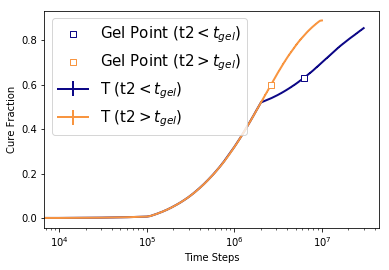

In [6]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
lines=[]
df_filtered = df[(df.activation_energy==3.0)&
                 (df.stop_after_percent==100.0)&
                 (df.t1==1.05e5)&
                 (df.E_factor==1.0)&
                 (df.T2==1.2)&
                 (((df.t2==2005001)&(df.t_Final==3e7))|
                  ((df.t2==9505001)&(df.t_Final==1.0e7)))&
                 (df.n_particles==4e5)&
                 (df.profile=='ramp_up_and_down')]
df_sorted = df_filtered.sort_values('t2')
colors = plt.cm.plasma(np.linspace(0,0.75,len(df_sorted.groupby('t2'))))
for i,(key,dfgrp) in enumerate(df_sorted.groupby('t2')):
    times=[]
    cure_fractions=[]
    gel_points=[]
    cure_at_gel=[]
    #print(dfgrp.t_Final)
    for jobid in dfgrp.index:
        job=project.open_job(id=jobid)
        if job.isfile('out.log') and ('gel_point' in job.document) :
            data = np.genfromtxt(job.fn('out.log'),names=True)
            timesteps = data['timestep']
            cure_fraction = data['bond_percentAB']/100
            pops = [ i for i, (x, y) in enumerate(zip(timesteps[:-1],timesteps[1:])) if x>=y]
            if len(pops)>0:
                popi=pops[0]+1
                timesteps = np.asarray([x for i,x in enumerate(timesteps) if i!=popi])
                cure_fraction = np.asarray([x for i,x in enumerate(cure_fraction) if i!=popi])
                
            times.append(timesteps)
            cure_fractions.append(cure_fraction)
            gel_points.append(job.document['gel_point'])
            cure_at_gel.append(job.document['curing_at_gel_point']/100)
    if key<gel_point:
        label='T (t2'+'$< t_{gel}$)'
    else:
        label='T (t2'+'$> t_{gel}$)'
    ax1.errorbar(np.mean(times,axis=0),
                 np.mean(cure_fractions,axis=0),
                 np.std(cure_fractions,axis=0),
                 label=label,#'t2: {:.1e}'.format(key),
                 color=colors[i],
                 linewidth=2.0,
                 zorder=0)
    if key<gel_point:
        label='Gel Point (t2'+'$< t_{gel}$)'
    else:
        label='Gel Point (t2'+'$> t_{gel}$)'
    ax1.scatter(np.mean(gel_points),
               np.mean(cure_at_gel),
                marker='s',
                facecolor='w',
                linewidth=1.0,
                color=colors[i],
               zorder=1,
               label=label)#'Gel Point({:.1e})'.format(key))
ax1.set_xlabel('Time Steps')
ax1.set_ylabel('Cure Fraction')
plt.legend(fontsize=15)
plt.xscale('log')
savefig(plt,
       'sensitivity_analysis_t2_N_4e5',
       'cure_profiles.pdf')
plt.show()   

[2005001. 2005001. 2005001. 9505001. 9505001. 9505001.]
min t2 9505001.0
max t2 9505001.0
a52a2aacf366f4bfdb526c3c90a6e553  not completed!
0.23446066894915651 -3.5471132590244467
0.20248875954699877 -3.5527970868063505


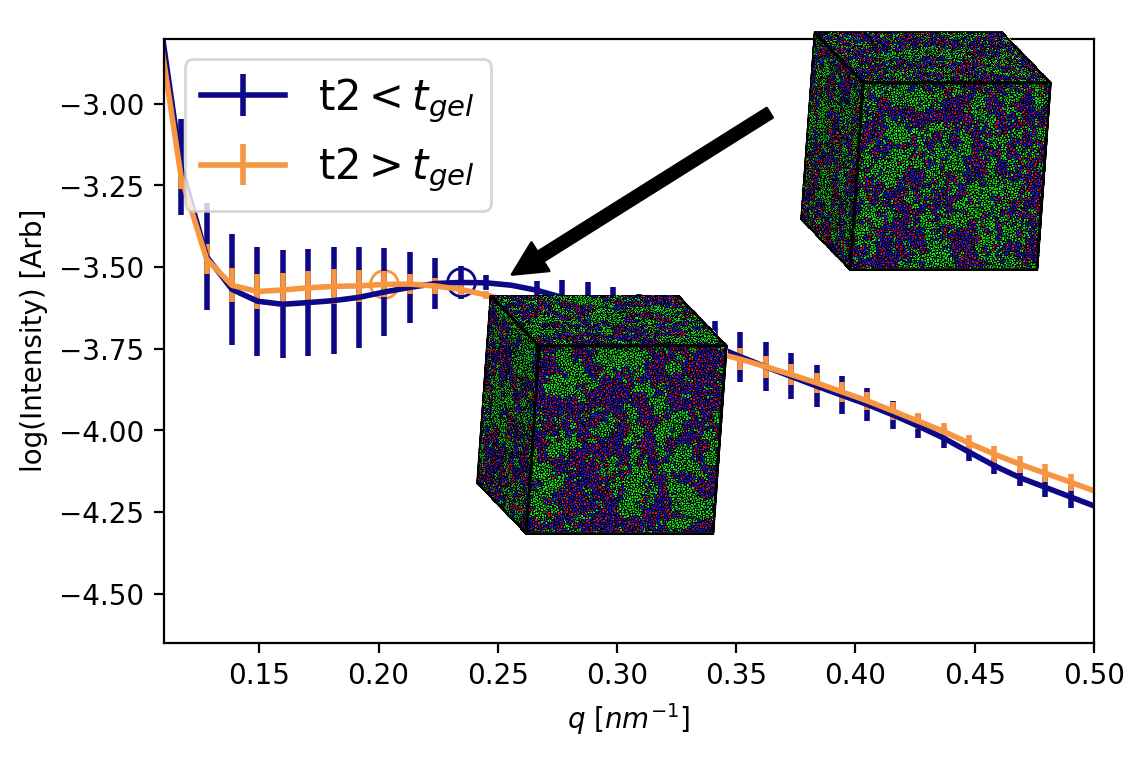

In [7]:
from scipy import stats
from scipy import interpolate
fig = plt.figure(dpi=200)
ax1 = fig.add_subplot(111) 
left, bottom, width, height = [0.34, 0.26, 0.3, 0.3]#[0.6, 0.57, 0.3, 0.3]#max t2
ax2 = fig.add_axes([left, bottom, width, height])
ax2.axis('off')
left, bottom, width, height = [0.61, 0.59, 0.3, 0.3]#[0.23, 0.27, 0.3, 0.3]#min t2
ax3 = fig.add_axes([left, bottom, width, height])
ax3.axis('off')
df_filtered = df[(df.activation_energy==3.0)&
                 (df.stop_after_percent==100.0)&
                 (df.t1==1.05e5)&
                 (df.E_factor==1.0)&
                 (df.T2==1.2)&
                 (((df.t2==2005001)&(df.t_Final==3e7))|
                  ((df.t2==9505001)&(df.t_Final==1.0e7)))&
                 (df.n_particles==4e5)&
                 (df.profile=='ramp_up_and_down')]
#print(df_filtered.profile)
df_sorted = df_filtered.sort_values('t2')
print(df_sorted.t2.values)
print('min t2',df_sorted.t2[3])#.min())
print('max t2',df_sorted.t2.max())
t2_min = 2005001#df_sorted.t2[3]#.min()
t2_max = 9505001#df_sorted.t2.max()#df_sorted.t2.max()
colors = plt.cm.plasma(np.linspace(0,0.75,len(df_sorted.groupby('t2'))))

df_gp = df_sorted.groupby('t2')
for i,(key,df_grp) in enumerate(df_gp):
    qs_all_trials = []
    Is_all_trials = []
    box_len = df_grp.Lx.mean()
    cure_percent = df_grp.cure_percent.mean()
    #print('cure_percent',cure_percent)
    if key ==t2_max  or key==t2_min:
        #print('key',key)
        for jobid in df_grp.index:
            job=project.open_job(id=jobid)
            if job.isfile('out.log') and ('gel_point' in job.document) :
                #print(job,key)
                gel_point = job.document['gel_point']
                A=job.sp.num_a*job.sp.n_mul*4*job.sp.percent_bonds_per_step/100/job.sp.bond_period
                if job.isfile('diffract_type_2/asq.txt'):
                    data = np.genfromtxt(job.fn('diffract_type_2/asq.txt'))
                    qs=data[:,0]
                    Is=data[:,1]
                    qs_all_trials.append(qs)
                    Is_all_trials.append(Is)
                    if job.isfile('final_snapshot.png'):
                        im = plt.imread(job.fn('final_snapshot.png'))
                        if key ==t2_max:
                            #ax2.set_title('t2 : {:.1e} $\\Delta$ t'.format(key),fontsize=15)
                            ax2.imshow(im)
                        if key ==t2_min:
                            #ax3.set_title('t2 : {:.1e} $\\Delta$ t'.format(key),fontsize=15)
                            ax3.imshow(im)
                    #print('Is',Is)
                else:
                    raise FileNotFoundError('Cannot find diffract_type_2/asq.txt for'+job)
            else:
                print(job,' not completed!')
    if len(Is_all_trials)>0:
        mean_qs = np.mean(qs_all_trials,axis=0)
        mean_Is = np.mean(Is_all_trials,axis=0)
        if key<gel_point:
            label='t2'+'$< t_{gel}$'
        else:
            label='t2'+'$> t_{gel}$'
        ax1.errorbar(mean_qs,
                     mean_Is,
                     yerr=stats.sem(Is_all_trials,axis=0),
                     linewidth=2.0,
                     zorder=1,
                     color=colors[i],
                 label=label)#'t2 : {:.1e} $\\Delta$ t'.format(key,
                   #                                                          cure_percent/100))
        if True:
            qms=[]
            Ims=[]
            for qs_t,Is_t in zip(qs_all_trials,Is_all_trials):
                first_peak_q,first_peak_i = get_highest_maxima(box_len,qs_t,Is_t)
                qms.append(first_peak_q)
                Ims.append(first_peak_i)
            #print(qms)
            fn = interpolate.interp1d(mean_qs,mean_Is,kind='cubic')
            first_peak_q=np.mean(qms)
            first_peak_i=fn(first_peak_q)
        else:
            first_peak_q,first_peak_i = get_highest_maxima(box_len,
                                                           mean_qs,
                                                           nmean_Is)
        print(first_peak_q,first_peak_i)
        if first_peak_q is None:
            #print(q_half_length)
            fn = interpolate.interp1d(qs,Is,kind='cubic')
            first_peak_q=q_half_length
            first_peak_i=fn(first_peak_q)
        if first_peak_q >0.8:
            fn = interpolate.interp1d(qs,Is,kind='cubic')
            first_peak_q=q_half_length
            first_peak_i=0#fn(first_peak_q)
        ax1.scatter(first_peak_q,
               first_peak_i,
               color=colors[i],
                zorder=0,
                    s=100,
                    facecolor='w',
                marker='o')

ax1.set_xlabel(r"$q$ [$nm^{-1}$]")
ax1.set_ylabel("log(Intensity) [Arb]")
ax1.set_xlim(0.11,0.5)
ax1.set_ylim(-4.65,-2.8)
ax1.legend(fontsize=15,loc='upper left')
ax1.annotate('', xy=(0.25, -3.6), xytext=(0.27, -4.0),arrowprops=dict(facecolor='black', shrink=0.05))
ax1.annotate('', xy=(0.25, -3.55), xytext=(0.37, -3.),arrowprops=dict(facecolor='black', shrink=0.05))
savefig(plt,
       'sensitivity_analysis_t2_N_4e5',
       'sf_vertical.pdf')